<a href="https://colab.research.google.com/github/juandsep/imbd_project/blob/master/imbd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#cargar librerias
import json
import numpy as np
import pandas as pd
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import pandas_profiling
from wordcloud import WordCloud, STOPWORDS 
% matplotlib inline

In [0]:
pip install pandas-profiling

In [3]:
#Carga de archivo a colab
from google.colab import files
uploaded = files.upload()


Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv
Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


In [4]:
#Cargar y revisar data
import io
credits = pd.read_csv(io.BytesIO(uploaded["tmdb_5000_credits.csv"]))
movies = pd.read_csv(io.BytesIO(uploaded['tmdb_5000_movies.csv']))
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [5]:
#los dataset ahora esta guardado
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.20,11800


In [0]:
#tratamiento de data para credits
#json data
json_fields = ['cast', 'crew']
for field in json_fields:
  credits[field] = credits[field].apply(lambda data: [row['name'] for row in json.loads(data)])

In [7]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B..."


In [0]:
#tratamiendo de data para movies
#json data
json_fields = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
for field in json_fields:
  movies[field] = movies[field].apply(lambda data: [row['name'] for row in json.loads(data)])

In [9]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.44,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.00,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.20,11800


In [10]:
#revisar info data y valores nulos
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [11]:
movies.describe()
#hay valores atipicos, como en pop, pero son "normales"
#zero values

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.00,4803.00,4803.00,4803.00,4801.00,4803.00,4803.00
mean,29045039.88,57165.48,21.49,82260638.65,106.88,6.09,690.22
std,40722391.26,88694.61,31.82,162857100.94,22.61,1.19,1234.59
min,0.00,5.00,0.00,0.00,0.00,0.00,0.00
25%,790000.00,9014.50,4.67,0.00,94.00,5.60,54.00
50%,15000000.00,14629.00,12.92,19170001.00,103.00,6.20,235.00
75%,40000000.00,58610.50,28.31,92917187.00,118.00,6.80,737.00
max,380000000.00,459488.00,875.58,2787965087.00,338.00,10.00,13752.00


In [12]:
#contar valores en zero para presupuesto
df = movies.groupby('budget').count()['id']
df.head()
#hay valores en cero

budget
0    1037
1       7
2       1
3       1
4       2
Name: id, dtype: int64

In [13]:
#contar valores en zero para presupuesto
df = movies.groupby('revenue').count()['id']
df.head()
#hay valores en cero

revenue
0     1427
5        1
7        2
10       1
11       2
Name: id, dtype: int64

In [0]:
#covertir data y ceros
#movies.drop_duplicates(keep='first', inplace=True)
cols = ['budget', 'revenue']
movies[cols] = movies[cols].applymap(np.int64)
movies[cols] = movies[cols].replace(0, np.nan)
movies.dropna(subset=cols, inplace=True)
#eliminando los valores en cero

In [0]:
#asignar formato fechas y calcular año de lanzamiento
movies.release_date = pd.to_datetime(movies['release_date'])
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month

In [0]:
#crear variables: beneficios
movies['profit'] = movies['revenue'] - movies['budget']

def format_number_for_axis(value, tick_number):
  if np.abs(value) >= 1000000000:
    return "{0}B".format(value / 1000000000)
  elif np.abs(value) >= 1000000:
    return "{0}M".format(value / 1000000)
  else:
    return value

In [17]:
#10 primeras peliculas con mayor presupuesto
movies[['title', 'budget', 'release_year']].sort_values(by='budget', ascending=False).head(n=10)

,title,budget,release_year
17,Pirates of the Caribbean: On Stranger Tides,380000000.00,2011
1,Pirates of the Caribbean: At World's End,300000000.00,2007
7,Avengers: Age of Ultron,280000000.00,2015
10,Superman Returns,270000000.00,2006
4,John Carter,260000000.00,2012
6,Tangled,260000000.00,2010
5,Spider-Man 3,258000000.00,2007
13,The Lone Ranger,255000000.00,2013
98,The Hobbit: An Unexpected Journey,250000000.00,2012
26,Captain America: Civil War,250000000.00,2016


In [18]:
#10 primeras peliculas con mayor ingreso
movies[['title', 'revenue', 'release_year']].sort_values(by='revenue', ascending=False).head(n=10)

,title,revenue,release_year
0,Avatar,2787965087.00,2009
25,Titanic,1845034188.00,1997
16,The Avengers,1519557910.00,2012
28,Jurassic World,1513528810.00,2015
44,Furious 7,1506249360.00,2015
7,Avengers: Age of Ultron,1405403694.00,2015
124,Frozen,1274219009.00,2013
31,Iron Man 3,1215439994.00,2013
546,Minions,1156730962.00,2015
26,Captain America: Civil War,1153304495.00,2016


In [19]:
#10 primeras peliculas mas rentables
movies[['title', 'profit', 'release_year']].sort_values(by='profit', ascending=False).head(n=10)

,title,profit,release_year
0,Avatar,2550965087.00,2009
25,Titanic,1645034188.00,1997
28,Jurassic World,1363528810.00,2015
44,Furious 7,1316249360.00,2015
16,The Avengers,1299557910.00,2012
7,Avengers: Age of Ultron,1125403694.00,2015
124,Frozen,1124219009.00,2013
546,Minions,1082730962.00,2015
329,The Lord of the Rings: The Return of the King,1024888979.00,2003
31,Iron Man 3,1015439994.00,2013


In [20]:
#10 ultimas peliculas
movies[['title', 'profit', 'release_year']].sort_values(by='profit', ascending=True).head(n=10)

,title,profit,release_year
13,The Lone Ranger,-165710090.00,2013
338,The Alamo,-119180039.00,2004
141,Mars Needs Moms,-111007242.00,2011
208,The 13th Warrior,-98301101.00,1999
311,The Adventures of Pluto Nash,-92896027.00,2002
2638,Metropolis,-91969578.00,1927
340,Cutthroat Island,-87982678.00,1995
142,Flushed Away,-84540684.00,2006
192,Australia,-80445998.00,2008
272,Town & Country,-79627709.00,2001


In [21]:
#10 peliculas populares
movies[['title', 'popularity', 'release_year']].sort_values(by='popularity', ascending=False).head(n=10)

,title,popularity,release_year
546,Minions,875.58,2015
95,Interstellar,724.25,2014
788,Deadpool,514.57,2016
94,Guardians of the Galaxy,481.10,2014
127,Mad Max: Fury Road,434.28,2015
28,Jurassic World,418.71,2015
199,Pirates of the Caribbean: The Curse of the Bla...,271.97,2003
82,Dawn of the Planet of the Apes,243.79,2014
200,The Hunger Games: Mockingjay - Part 1,206.23,2014
88,Big Hero 6,203.73,2014


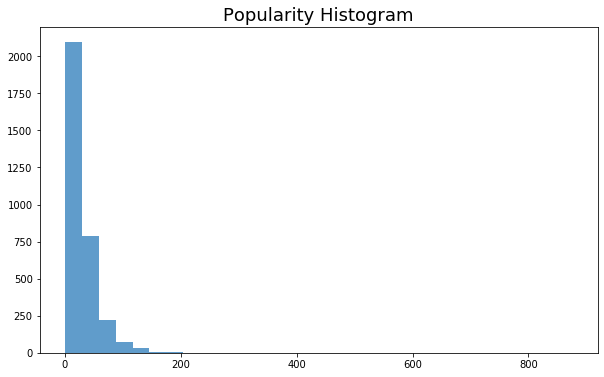

In [22]:
plt.subplots(figsize=(10, 6))
plt.hist(movies['popularity'], 30, facecolor=sns.color_palette("Blues")[4], alpha=0.75)
plt.title("Popularity Histogram", fontsize=18)
plt.show()

In [23]:
#10 peliculas populares
movies[['title', 'popularity', 'release_year']].sort_values(by='popularity', ascending=True).head(n=10)

,title,popularity,release_year
3921,Woman Thou Art Loosed,0.02,2004
4105,"The Book of Mormon Movie, Volume 1: The Journey",0.03,2003
3225,Limbo,0.03,1999
2970,There Goes My Baby,0.04,1994
4065,Mi America,0.04,2015
3471,Dolphins and Whales: Tribes of the Ocean,0.04,2008
4371,Fiza,0.04,2000
3419,Bran Nue Dae,0.05,2009
4617,Ayurveda: Art of Being,0.06,2001
2303,The Nutcracker,0.07,1993


In [24]:
#analisis de conrrelaciones entre algunas variables
movies[['vote_average', 'popularity', 'runtime', 'profit']].corr()

,vote_average,popularity,runtime,profit
vote_average,1.00,0.29,0.38,0.23
popularity,0.29,1.00,0.18,0.59
runtime,0.38,0.18,1.00,0.21
profit,0.23,0.59,0.21,1.00


In [25]:
#covarianzas
movies[['vote_average', 'popularity', 'runtime', 'profit']].cov()

,vote_average,popularity,runtime,profit
vote_average,0.76,9.07,6.94,31792668.09
popularity,9.07,1307.96,138.15,3364176223.57
runtime,6.94,138.15,439.56,696769729.12
profit,31792668.09,3364176223.57,696769729.12,25010773290193436.00


In [26]:
#nube de palabras
text = " ".join(overview for overview in movies.overview)
print ("There are {} words in the combination of all review.".format(len(text)))


There are 982335 words in the combination of all review.


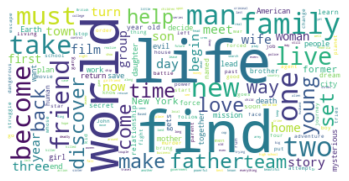

In [27]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["will"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
key_words = ' '
stopwords = set(STOPWORDS) 
genre_list = [genre for movie in movies['genres'] for genre in movie]
  

In [0]:
# iterate through the list for genre
for genre in genre_list: 
      
    # typecaste each genre to string 
    genre = str(genre) 
  
    # split the value 
    tokens = genre.split()
             
    # Converts each token into lowercase 
    #for i in range(len(tokens)): 
    #    tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      key_words = key_words + words + " "

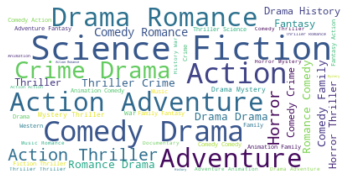

In [30]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(key_words)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

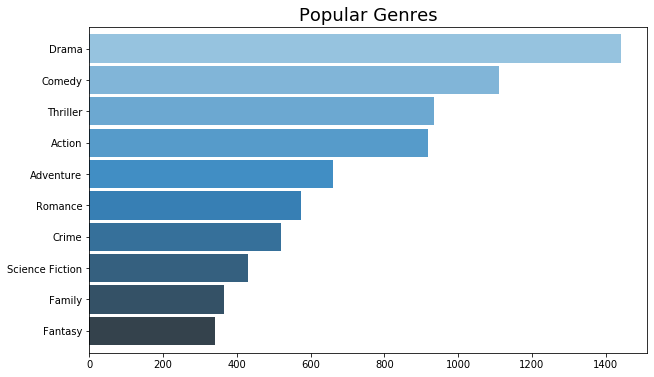

In [31]:
#grafica> popularidad de generos
plt.subplots(figsize=(10, 6))
# value_counts() returns sorted list. Reverse it to make item 1 of top 10 appear at top of chart
genre_count_series = pd.Series(genre_list).value_counts()[:10].sort_values(ascending=True)
ax = genre_count_series.plot.barh(width=0.9, color=sns.color_palette('Blues_d', 10))
plt.title("Popular Genres", fontsize=18)
plt.show()

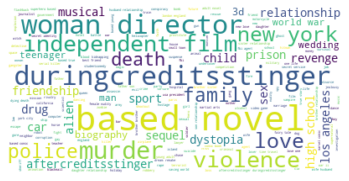

In [33]:
key_words = ' '
stopwords = set(STOPWORDS) 
keywords_list = [keywords for movie in movies['keywords'] for keywords in movie]
# iterate through the list for keywords
for keywords in keywords_list: 
      
    # typecaste each keywords to string 
    keywords = str(keywords) 
  
    # split the value 
    tokens = keywords.split()
             
    # Converts each token into lowercase 
    #for i in range(len(tokens)): 
    #    tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      key_words = key_words + words + " "
  

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(key_words)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


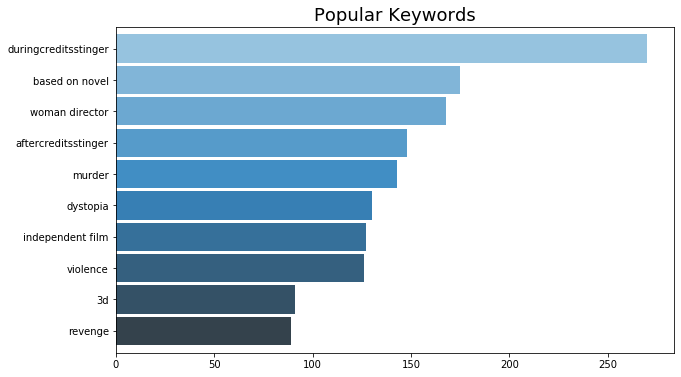

In [34]:
#grafica> popularidad de generos
plt.subplots(figsize=(10, 6))
# Flatten the arrays of keywords in each row
# value_counts() returns sorted list. Reverse it to make item 1 of top 10 appear at top of chart
keywords_count_series = pd.Series(keywords_list).value_counts()[:10].sort_values(ascending=True)
ax = keywords_count_series.plot.barh(width=0.9, color=sns.color_palette('Blues_d', 10))
plt.title("Popular Keywords", fontsize=18)
plt.show()

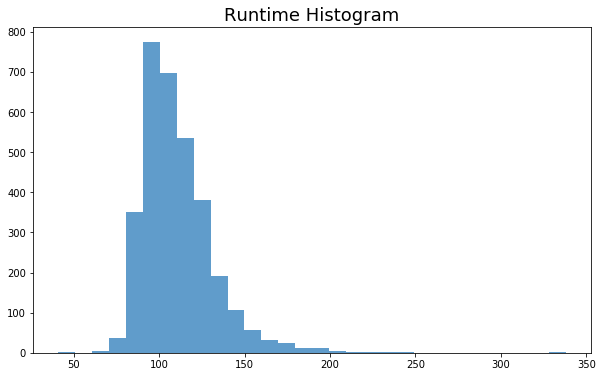

In [35]:
plt.subplots(figsize=(10, 6))
plt.hist(movies['runtime'], 30, facecolor=sns.color_palette("Blues")[4], alpha=0.75)
plt.title("Runtime Histogram", fontsize=18)
plt.show()

In [36]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3229 entries, 0 to 4798
Data columns (total 23 columns):
budget                  3229 non-null float64
genres                  3229 non-null object
homepage                1347 non-null object
id                      3229 non-null int64
keywords                3229 non-null object
original_language       3229 non-null object
original_title          3229 non-null object
overview                3229 non-null object
popularity              3229 non-null float64
production_companies    3229 non-null object
production_countries    3229 non-null object
release_date            3229 non-null datetime64[ns]
revenue                 3229 non-null float64
runtime                 3229 non-null float64
spoken_languages        3229 non-null object
status                  3229 non-null object
tagline                 2984 non-null object
title                   3229 non-null object
vote_average            3229 non-null float64
vote_count              32

In [37]:
#movies.dtypes
movies2 = movies[movies.release_year < 1960]
movies2.describe()                     


,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year,release_month,profit
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,3640293.71,17180.38,15.07,26720716.67,119.19,6.96,337.13,1945.11,7.40,23080422.95
std,11508156.59,17690.64,18.62,63206989.67,31.54,0.81,512.63,9.60,3.67,64649533.99
min,1.00,19.00,0.18,25.00,66.00,4.80,4.00,1916.00,1.00,-91969578.00
25%,1000000.00,849.00,1.99,6000000.00,101.00,6.55,24.50,1939.00,4.00,4381107.50
50%,2000000.00,11219.00,7.60,9000000.00,115.00,7.00,79.00,1946.00,8.00,7172000.00
75%,3090000.00,31135.50,18.54,18985162.00,130.00,7.60,346.50,1953.00,11.00,14485162.00
max,92620000.00,65203.00,80.17,400176459.00,238.00,8.20,2078.00,1959.00,12.00,396176459.00


In [38]:
# compute the mean for popularity
p_mean = movies.groupby('release_year').mean()['popularity']
p_mean.tail()

# compute the median for popularity
p_median = movies.groupby('release_year').median()['popularity']
p_median.tail()

release_year
2012   27.91
2013   34.61
2014   42.47
2015   40.37
2016   42.52
Name: popularity, dtype: float64

In [0]:
# build the index location for x-axis
index_mean = p_mean.index
index_median = p_median.index

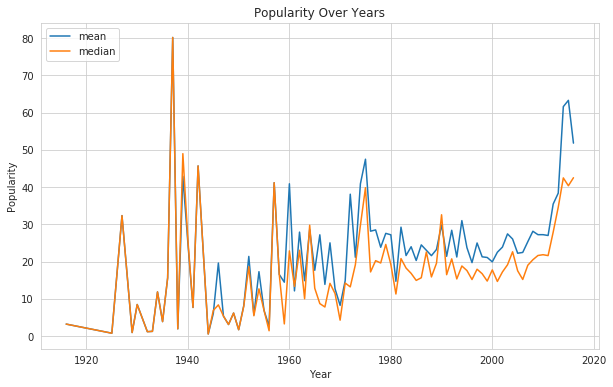

In [40]:
#set style
sns.set_style('whitegrid')
#set x, y axis data
#x1, y1 for mean data; x2, y2 for median data
x1, y1 = index_mean, p_mean
x2, y2 = index_median, p_median
#set size
plt.figure(figsize=(10, 6))
#plot line chart for mean and median
plt.plot(x1, y1, label = 'mean')
plt.plot(x2, y2, label = 'median')
#set title and labels
plt.title('Popularity Over Years')
plt.xlabel('Year')
plt.ylabel('Popularity');
#set legend
plt.legend(loc='upper left')
plt.show()

In [0]:
moviesdf = pd.DataFrame(movies)
pandas_profiling.ProfileReport(moviesdf)

In [42]:
#realizar conteo de peliculas por años
df_year = movies.groupby('release_year').count()['id']
df_year.head()

release_year
1916    1
1925    1
1927    1
1929    1
1930    1
Name: id, dtype: int64

Text(0, 0.5, 'Number of Movie Released')

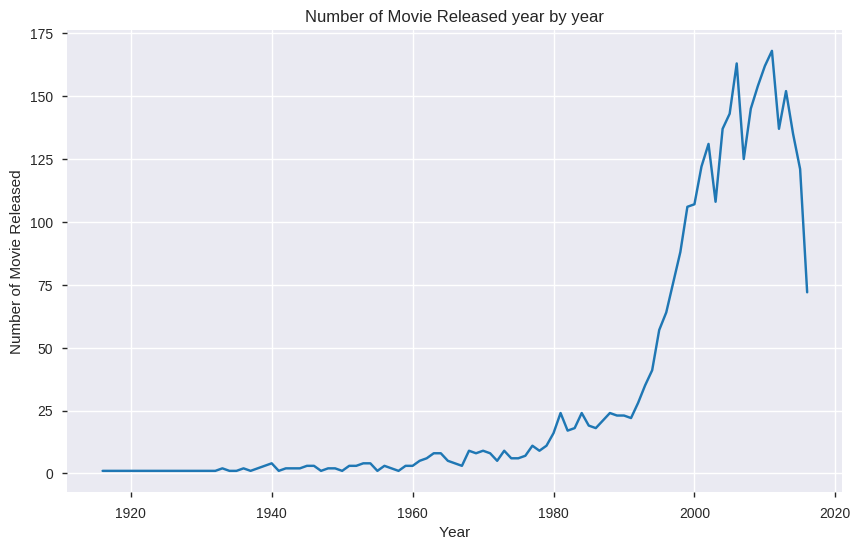

In [43]:
# x is movie release year
x = df_year.index
# y is number of movie released
y = df_year
#set size
plt.figure(figsize=(10, 6))
#plot line chart 
plt.plot(x, y, label = 'Conteo')
#set title and labels
plt.title('Number of Movie Released year by year')
plt.xlabel('Year')
plt.ylabel('Number of Movie Released')

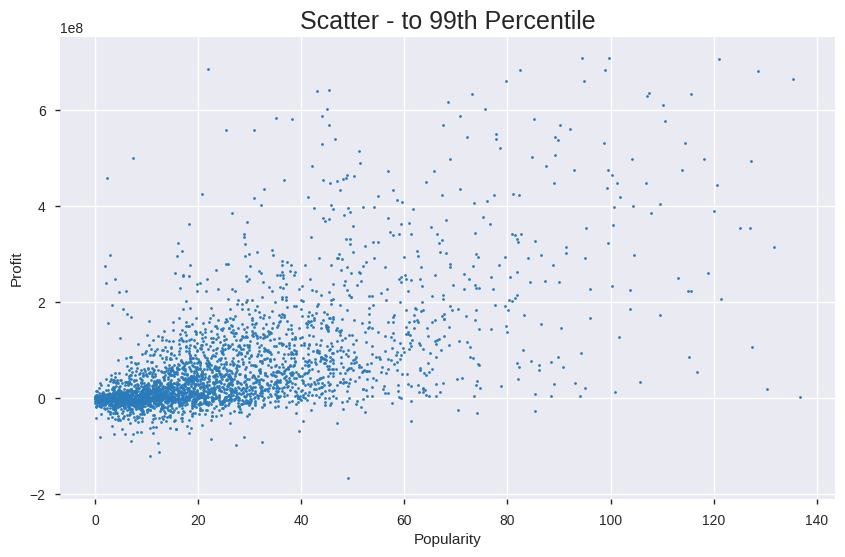

In [44]:
#graficos de relaciones
plt.subplots(figsize=(10, 6))
# Select the fields
df = movies[['popularity', 'profit']]
# Normalise
#scatter = (df - df.min()) / (df.max() - df.min())
# Filter outliers, using 99th percentile values
df = df[df.popularity <= df.popularity.quantile(0.99)]
df = df[df.profit <= df.profit.quantile(0.99)]
# Create a scatter plot
plt.plot(df['popularity'], df['profit'], 'o', color=sns.color_palette("Blues")[4], markersize=2)
plt.title("Scatter - to 99th Percentile", fontsize=18)
plt.xlabel("Popularity")
plt.ylabel("Profit")
plt.show()

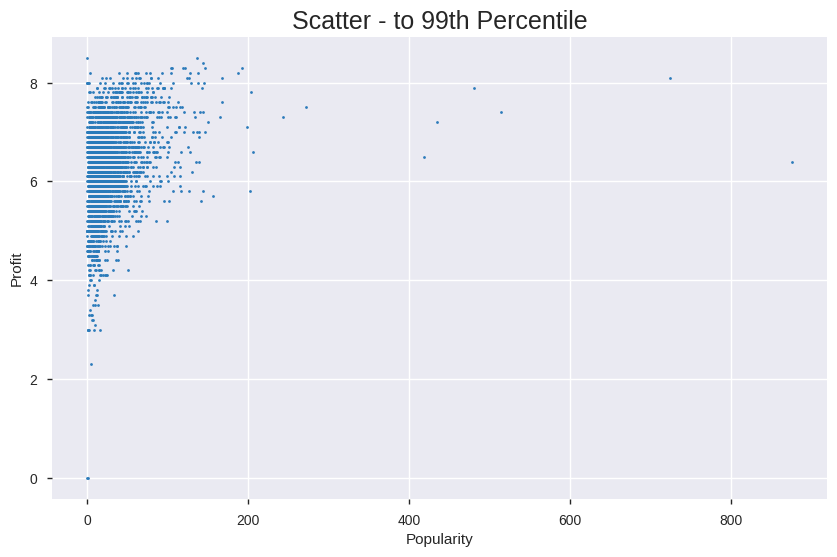

In [45]:
#graficos de relaciones
plt.subplots(figsize=(10, 6))
# Select the fields
df = movies[['popularity', 'vote_average']]
# Normalise
#scatter = (df - df.min()) / (df.max() - df.min())
# Filter outliers, using 99th percentile values
#df = df[df.popularity <= df.popularity.quantile(0.99)]
#df = df[df.vote_average <= df.vote_average.quantile(0.99)]
# Create a scatter plot
plt.plot(df['popularity'], df['vote_average'], 'o', color=sns.color_palette("Blues")[4], markersize=2)
plt.title("Scatter - to 99th Percentile", fontsize=18)
plt.xlabel("Popularity")
plt.ylabel("Profit")
plt.show()